# Capítulo 14 - Generative Adversarial Networks

En este capítulo introducimos las redes conocidas como Generative Adversarial Networks (GAN), que están generando un gran intereés al ser las responsables en gran medida de las *deepfakes*. Estoy seguro de que resultará interesante para el lector o lectroa acabar el libro con este tema tan actual. Aprovecharemos la explicación de las GAN para introducir ootros tipos de capas de redes no vistas hasta ahora, y alternativas de programación de la API de Keras hasta ahora en el entorno TensorFlow 2.0. 

## 14.1. Generative Adversarial Networks

### 14.1.1. Motivación por las GAN

### 14.1.2. Arquitectura de las GAN

### 14.1.3. Proceso de entrenamiento

## 14.2. Programando una GAN

### 14.2.1. Preparación del entrono y la descarga de datos

Pasamos a codificar nuestro ejemplo, comenzando por preparar el entorno:

In [20]:
#%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

print(tf.config.list_physical_devices('GPU'))

2.10.0
['/device:CPU:0', '/device:GPU:0']
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Es importante asegurarse de que estamos usando TensorFlow 2. Además, también es relevante comprobar que tenemos asignada una GPU, pues ahora la etapa de entrenamiento ya es computacionalmente costosa y se requiere *hardware* acelerador para asegurar que se ejecuta en un tiempo razonable. Podemos hacerlo ejecutando el comando *bash* de Linux `nvidia-smi`. 

In [21]:
!nvidia-smi

Thu Feb  8 20:29:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
| 52%   68C    P0             56W /  198W |    5166MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Vemos que en este caso tenemos asignada una P100, ¡no está mal! A continuación, podemos importar todos los paquetes necesarios para ejecutar el modelo propuesto:

In [22]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Ahora ya podemos descargar las imágenes de conjunto de datos MNIST de dígitos escritos a mano, que serán las imágenes que consideremos reales para nuestro ejemplo. Podemos hacerlo directamente desde `keras.datasets` y preparar las imágenes para ser usadas por las redes con el siguiente código:

In [23]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

En este caso solo nos interesan las imágenes y, por tanto, no descargamos ni las *labels* ni los datos de prueba (usaremos `_` para indicar que no necesitamos estos datos y que pueden ser desechables).

Podemos ver en el código que estas imágenes se han normalizado en el rango [-1, 1] para poder usar como función de activación en la capa final del Generador la funcion `tanh`, como veremos a continuación:

In [24]:
train_images = (train_images - 127.5) / 127.5

Barajamos y preparamos los datos en lotes con el siguiente código:

In [25]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 14.2.2. Creación de los modelos

A continuación, ya podemos pasar a crear las redes neuronales que actuarán de Generador y Discriminador.

#### 14.2.2.1. Generador

Siguiendo el esquema que habíamos descrito, el Generador recibe como entrada ruido, que puede obtener por ejemplo con `tf.random.normal`. De este ruido debe crear una imagen de 28 x 28 píxeles.

El generador que obtiene una imagen de estas características a partir del vector de ruido que hemos indicado podría ser como el programado en el siguiente código:

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

generator = make_generator_model()

print(generator.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      819328    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)      

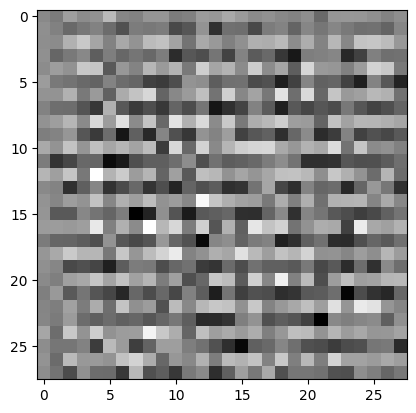

In [27]:
noise_dim = 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### 14.2.2.2. Discriminador

In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU, Conv2D

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         204928    
                                                      

In [29]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.500905]], shape=(1, 1), dtype=float32)


In [30]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [32]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [36]:
import time

grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    print ('Processing epoch {}'.format(epoch + 1))

    for image_batch in dataset:
      train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  generate_images(generator, seed)

In [37]:
def generate_images(model, test_input):
  
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(grid_size_x,grid_size_y))
  for i in range(predictions.shape[0]):
      plt.subplot(grid_size_x, grid_size_y, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')            
  plt.show()

Processing epoch 1


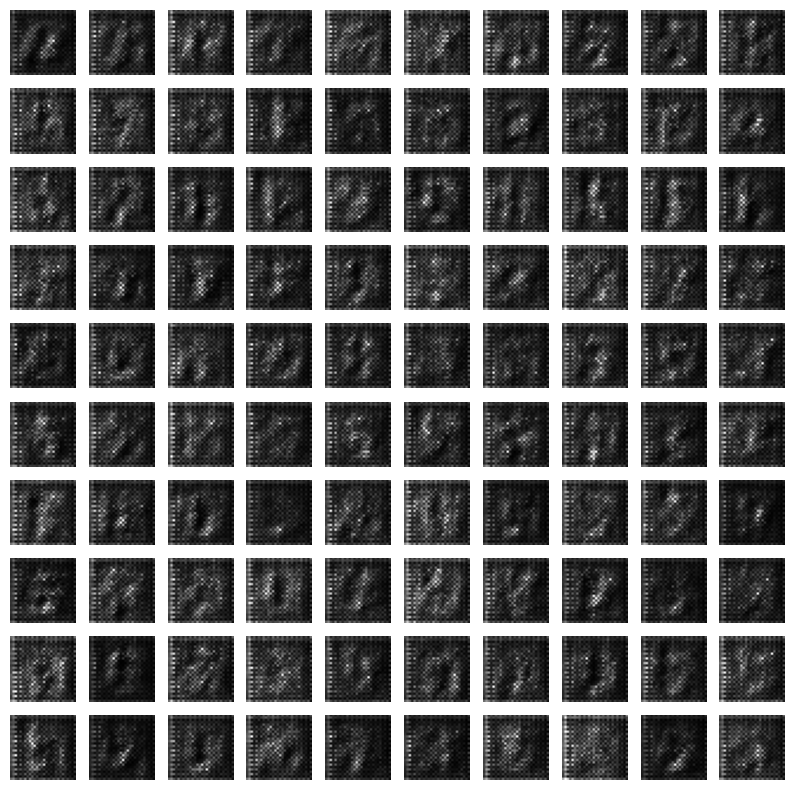

Time for epoch 1 is 16.616962671279907 sec
Processing epoch 2


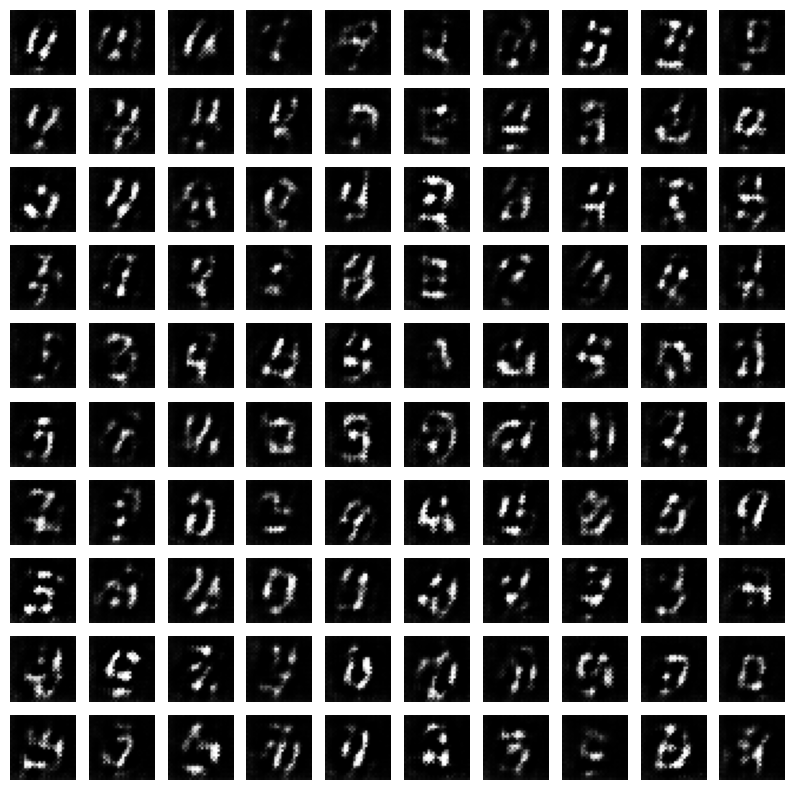

Time for epoch 2 is 14.281430006027222 sec
Processing epoch 3


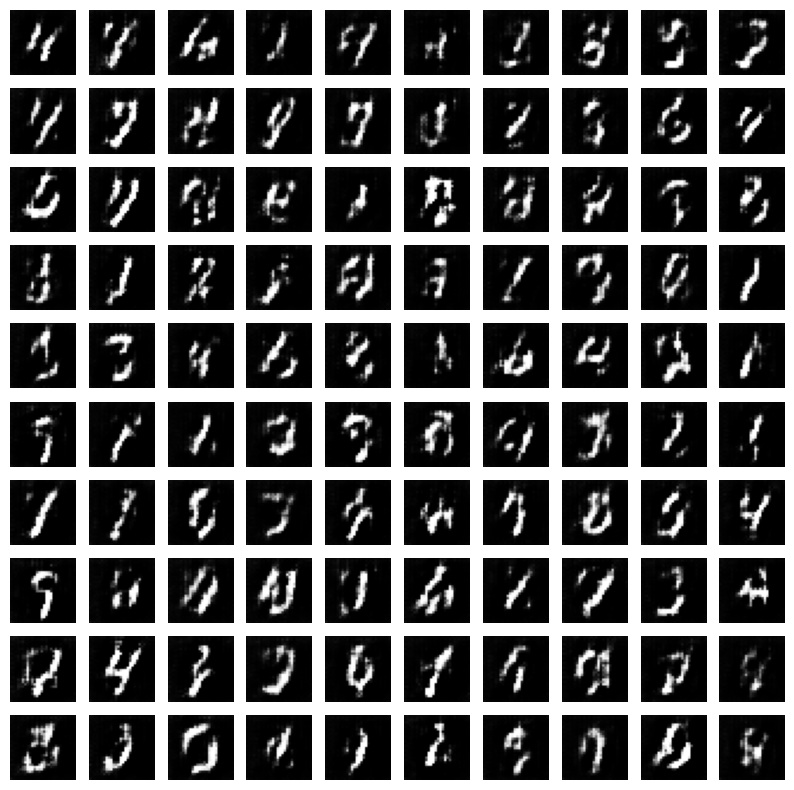

Time for epoch 3 is 14.830851078033447 sec
Processing epoch 4


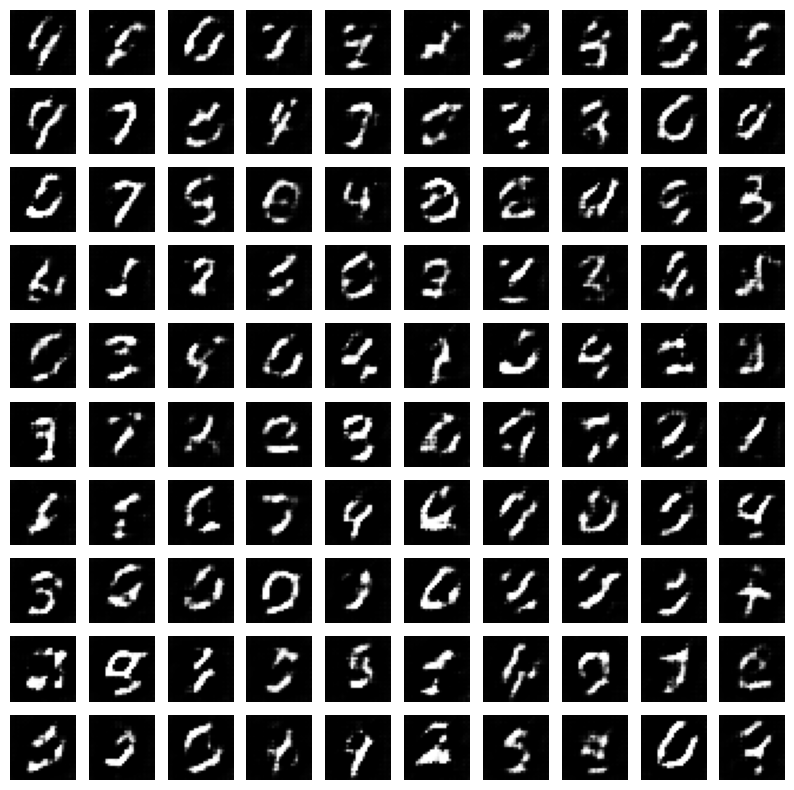

Time for epoch 4 is 14.270442008972168 sec
Processing epoch 5


In [38]:
EPOCHS = 2000
train(train_dataset, EPOCHS)

### 14.2.3. Funciones de pérdida y optimizadores

## 14.3. Enrutamiento de la API de bajo nivel de TensorFlow

### 14.2.1. API de bajo nivel de TensorFlow

### 14.2.2. Algoritmo de aprendizaje a bajo nivel

### 14.2.3. Entrenamiento de las redes GAN

### 14.2.4. Mejora del rendimiento computacional con decoradores de funciones

### 14.2.5. Evaluación de los resultados